Лабораторная работа 4

Исследование алгоритма случайного леса на задачах классификации Phishing Websites и регрессии Combined Cycle Power Plant

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    mean_absolute_error,
    r2_score
)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

RANDOM_STATE = 42


Задаем вспомогательные функции для регрессионных метрик и матрицы ошибок чтобы не дублировать код

In [2]:
def regression_metrics_map(y_true, y_pred):
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    mae = float(mean_absolute_error(y_true, y_pred))
    r2 = float(r2_score(y_true, y_pred))
    return {"RMSE": rmse, "MAE": mae, "R2": r2}


def plot_confusion(cm, title, labels=None):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Purples")
    plt.title(title)
    plt.tight_layout()
    plt.show()

Загружаем датасет Phishing Websites из OpenML и энергетический датасет CCPP из локального файла и разбиваем данные на обучение и тест

In [3]:
# Классификация Phishing Websites
ds = fetch_openml(data_id=4534, as_frame=True)
df = ds.frame.copy()

y_cls = (df['Result'].astype(int) == 1).astype(int).to_numpy()
X_cls = df.drop(columns=['Result']).replace('?', np.nan).apply(pd.to_numeric, errors='coerce')

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_cls,
    y_cls,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_cls
)

print('Баланс train:', np.unique(yc_train, return_counts=True))
print('Баланс test :', np.unique(yc_test, return_counts=True))

reg_path = '../datasets/Folds5x2_pp.xlsx'
try:
    df_reg = pd.read_excel(reg_path)
except FileNotFoundError:
    raise FileNotFoundError('Поместите рядом файл Folds5x2_pp.xlsx')

y_reg = df_reg['PE'].to_numpy()
X_reg = df_reg.drop(columns=['PE'])

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg,
    y_reg,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print('Размеры регрессии:', Xr_train.shape, Xr_test.shape)


Баланс train: (array([0, 1]), array([3918, 4926], dtype=int64))
Баланс test : (array([0, 1]), array([ 980, 1231], dtype=int64))
Размеры регрессии: (7654, 4) (1914, 4)


Строим простые модели случайного леса без подбора параметров и фиксируем базовые метрики

Baseline classification {'Accuracy': 0.973767526006332, 'MacroF1': 0.973385196758356, 'ROC-AUC': 0.9974539531490907}


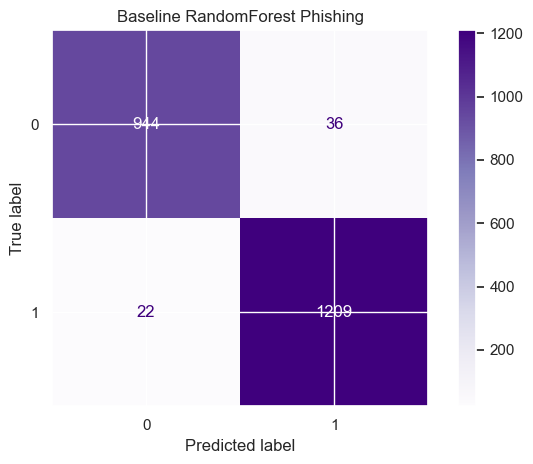

Baseline regression {'RMSE': 3.2325574259046173, 'MAE': 2.3153366248693814, 'R2': 0.9639746939044224}


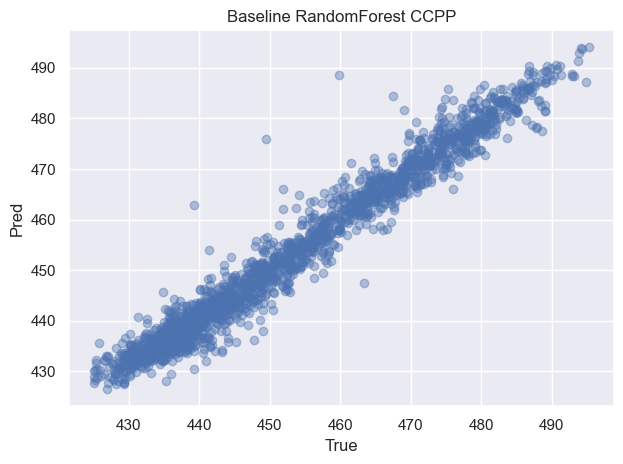

In [11]:
# Бейзлайн RandomForest для классификации
pipe_rf_c = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("rf", RandomForestClassifier(
        n_estimators=100,
        random_state=991,
        n_jobs=-1
    ))
])

pipe_rf_c.fit(Xc_train, yc_train)
yc0 = pipe_rf_c.predict(Xc_test)
yc0_proba = pipe_rf_c.predict_proba(Xc_test)[:, 1]

base_cls = {
    "Accuracy": accuracy_score(yc_test, yc0),
    "MacroF1": f1_score(yc_test, yc0, average="macro"),
    "ROC-AUC": roc_auc_score(yc_test, yc0_proba)
}
print("Baseline classification", base_cls)

cm0 = confusion_matrix(yc_test, yc0, labels=[0, 1])
plot_confusion(cm0, "Baseline RandomForest Phishing", labels=[0, 1])

# Бейзлайн RandomForest для регрессии
pipe_rf_r = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("rf", RandomForestRegressor(
        n_estimators=100,
        random_state=991,
        n_jobs=-1
    ))
])

pipe_rf_r.fit(Xr_train, yr_train)
yr0 = pipe_rf_r.predict(Xr_test)
base_reg = regression_metrics_map(yr_test, yr0)
print("Baseline regression", base_reg)

plt.figure()
plt.scatter(yr_test, yr0, alpha=0.4)
plt.xlabel("True")
plt.ylabel("Pred")
plt.title("Baseline RandomForest CCPP")
plt.tight_layout()
plt.show()

Пробуем улучшить лес за счет подбора числа деревьев глубины листьев и подпространства признаков на кросс валидации

Fitting 3 folds for each of 125 candidates, totalling 375 fits
Improved classification {'Accuracy': 0.9742198100407056, 'MacroF1': 0.9738411898463292, 'ROC-AUC': 0.9975177804671829}
Best params cls {'rf__n_estimators': 100, 'rf__min_samples_leaf': 1, 'rf__max_features': 'log2', 'rf__max_depth': None, 'rf__class_weight': None}


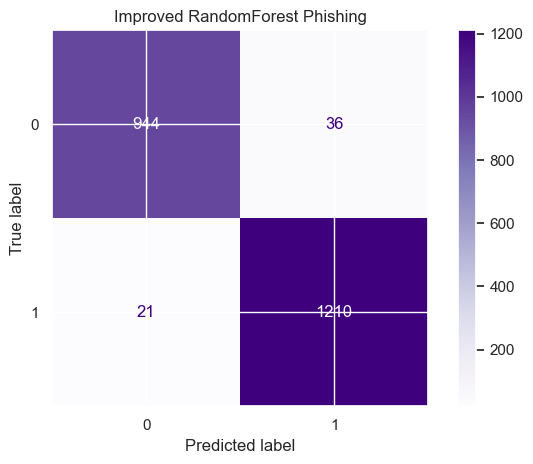

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [ ]:
cv_c = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_dist_c = {
    "rf__n_estimators": [100, 200, 300],
    "rf__max_depth": [None, 5, 10, 15],
    "rf__min_samples_leaf": [1, 2, 4],
    "rf__max_features": ["sqrt", "log2", 0.5],
    "rf__class_weight": [None, "balanced"]
}

rs_rf_c = RandomizedSearchCV(
    estimator=pipe_rf_c,
    param_distributions=param_dist_c,
    n_iter=125,
    scoring="f1_macro",
    n_jobs=-1,
    cv=cv_c,
    random_state=42,
    refit=True,
    verbose=1
)

rs_rf_c.fit(Xc_train, yc_train)

yc1 = rs_rf_c.predict(Xc_test)
yc1_proba = rs_rf_c.predict_proba(Xc_test)[:, 1]

imp_cls = {
    "Accuracy": accuracy_score(yc_test, yc1),
    "MacroF1": f1_score(yc_test, yc1, average="macro"),
    "ROC-AUC": roc_auc_score(yc_test, yc1_proba)
}
print("Improved classification", imp_cls)
print("Best params cls", rs_rf_c.best_params_)

cm1 = confusion_matrix(yc_test, yc1, labels=[0, 1])
plot_confusion(cm1, "Improved RandomForest Phishing", labels=[0, 1])

# Улучшение для регрессии
cv_r = KFold(n_splits=3, shuffle=True, random_state=42)

param_dist_r = {
    "rf__n_estimators": [100, 200, 300],
    "rf__max_depth": [None, 5, 10, 15],
    "rf__min_samples_leaf": [1, 2, 4],
    "rf__max_features": ["sqrt", "log2", 0.5]
}

rs_rf_r = RandomizedSearchCV(
    estimator=pipe_rf_r,
    param_distributions=param_dist_r,
    n_iter=50,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    cv=cv_r,
    random_state=42,
    refit=True,
    verbose=1
)

rs_rf_r.fit(Xr_train, yr_train)

yr1 = rs_rf_r.predict(Xr_test)
imp_reg = regression_metrics_map(yr_test, yr1)
print("Improved regression", imp_reg)
print("Best params reg", rs_rf_r.best_params_)

Сводим результаты в таблицы чтобы сравнить базовый лес и вариант после тюнинга

In [15]:
df_cls_cmp = pd.DataFrame([
    {"Model": "Baseline", **base_cls},
    {"Model": "Improved", **imp_cls}
])
print("Сравнение классификации")
display(df_cls_cmp.round(4))

df_reg_cmp = pd.DataFrame([
    {"Model": "Baseline", **base_reg},
    {"Model": "Improved", **imp_reg}
])
print("Сравнение регрессии")
display(df_reg_cmp.round(4))

Сравнение классификации


,Model,Accuracy,MacroF1,ROC-AUC
0,Baseline,0.9738,0.9734,0.9975
1,Improved,0.9742,0.9738,0.9975


Сравнение регрессии


,Model,RMSE,MAE,R2
0,Baseline,3.2326,2.3153,0.9640
1,Improved,3.0990,2.2138,0.9669


Реализуем упрощенный случайный лес на основе базовых деревьев чтобы руками повторить идею бэггинга

In [17]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor


class SimpleRFClassifier:
    def __init__(self, n_estimators=50, max_depth=None, max_features="sqrt", random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        self.trees_ = []
        self.rng_ = np.random.RandomState(random_state)

    def fit(self, X, y):
        n_samples = X.shape[0]
        self.trees_ = []
        for i in range(self.n_estimators):
            idx = self.rng_.choice(n_samples, size=n_samples, replace=True)
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                max_features=self.max_features,
                random_state=self.random_state + i
            )
            tree.fit(X[idx], y[idx])
            self.trees_.append(tree)
        return self

    def predict_proba(self, X):
        all_proba = [tree.predict_proba(X) for tree in self.trees_]
        proba = np.mean(all_proba, axis=0)
        return proba

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)


class SimpleRFRegressor:
    def __init__(self, n_estimators=50, max_depth=None, max_features="sqrt", random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        self.trees_ = []
        self.rng_ = np.random.RandomState(random_state)

    def fit(self, X, y):
        n_samples = X.shape[0]
        self.trees_ = []
        for i in range(self.n_estimators):
            idx = self.rng_.choice(n_samples, size=n_samples, replace=True)
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                max_features=self.max_features,
                random_state=self.random_state + i
            )
            tree.fit(X[idx], y[idx])
            self.trees_.append(tree)
        return self

    def predict(self, X):
        preds = [tree.predict(X) for tree in self.trees_]
        return np.mean(preds, axis=0)

Обучаем самописный лес на тех же данных и смотрим как он держится против sklearn реализации

In [18]:
imp_c = SimpleImputer(strategy="most_frequent").fit(Xc_train)
Xs_c_tr = imp_c.transform(Xc_train)
Xs_c_te = imp_c.transform(Xc_test)

imp_r = SimpleImputer(strategy="median").fit(Xr_train)
Xs_r_tr = imp_r.transform(Xr_train)
Xs_r_te = imp_r.transform(Xr_test)

s_rf_c = SimpleRFClassifier(n_estimators=50, max_depth=None, max_features="sqrt", random_state=42)
s_rf_c.fit(Xs_c_tr, yc_train)
ys_c = s_rf_c.predict(Xs_c_te)
ys_c_proba = s_rf_c.predict_proba(Xs_c_te)[:, 1]

scratch_cls = {
    "Accuracy": accuracy_score(yc_test, ys_c),
    "MacroF1": f1_score(yc_test, ys_c, average="macro"),
    "ROC-AUC": roc_auc_score(yc_test, ys_c_proba)
}
print("Scratch classification", scratch_cls)

s_rf_r = SimpleRFRegressor(n_estimators=50, max_depth=None, max_features="sqrt", random_state=42)
s_rf_r.fit(Xs_r_tr, yr_train)
ys_r = s_rf_r.predict(Xs_r_te)
scratch_reg = regression_metrics_map(yr_test, ys_r)
print("Scratch regression", scratch_reg)

Scratch classification {'Accuracy': 0.9755766621438263, 'MacroF1': 0.9752041502944915, 'ROC-AUC': 0.9974419337190603}
Scratch regression {'RMSE': 3.1451120994087662, 'MAE': 2.259226854754437, 'R2': 0.9658974039574061}


Финально сравниваем три варианта леса и формулируем общий вывод

In [19]:
df_cls_all = pd.DataFrame([
    {"Model": "Baseline", **base_cls},
    {"Model": "Improved", **imp_cls},
    {"Model": "Scratch", **scratch_cls}
])
print("Классификация RandomForest")
display(df_cls_all.round(4))

df_reg_all = pd.DataFrame([
    {"Model": "Baseline", **base_reg},
    {"Model": "Improved", **imp_reg},
    {"Model": "Scratch", **scratch_reg}
])
print("Регрессия RandomForest")
display(df_reg_all.round(4))

Классификация RandomForest


,Model,Accuracy,MacroF1,ROC-AUC
0,Baseline,0.9738,0.9734,0.9975
1,Improved,0.9742,0.9738,0.9975
2,Scratch,0.9756,0.9752,0.9974


Регрессия RandomForest


,Model,RMSE,MAE,R2
0,Baseline,3.2326,2.3153,0.9640
1,Improved,3.0990,2.2138,0.9669
2,Scratch,3.1451,2.2592,0.9659


Вывод случайный лес из коробки уже дает высокий уровень качества а аккуратный тюнинг числа деревьев глубины и признаков дает небольшой но стабильный прирост особенно на регрессии а упрощенный самописный лес ожидаемо немного проигрывает по метрикам и показывает как работает сама идея бэггинга без оптимизаций sklearn реализации